In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 7000], examples_per_second: 331.6770, train_label_loss: 2.7413, 


epoch: 1, [batch: 700 / 7000], examples_per_second: 10684.5747, train_label_loss: 2.5692, 


epoch: 1, [batch: 1400 / 7000], examples_per_second: 10662.3586, train_label_loss: 2.5623, 


epoch: 1, [batch: 2100 / 7000], examples_per_second: 10678.6551, train_label_loss: 2.3665, 


epoch: 1, [batch: 2800 / 7000], examples_per_second: 10674.9933, train_label_loss: 2.0208, 


epoch: 1, [batch: 3500 / 7000], examples_per_second: 10577.9657, train_label_loss: 1.8484, 


epoch: 1, [batch: 4200 / 7000], examples_per_second: 10630.3106, train_label_loss: 1.7889, 


epoch: 1, [batch: 4900 / 7000], examples_per_second: 10588.8566, train_label_loss: 1.7188, 


epoch: 1, [batch: 5600 / 7000], examples_per_second: 10609.4297, train_label_loss: 1.3784, 


epoch: 1, [batch: 6300 / 7000], examples_per_second: 11655.3348, train_label_loss: 1.4432, 


epoch: 1, source_val_acc_label: 0.6055, source_val_label_loss: 1.2103, target_val_acc_label: 0.6055, target_val_label_loss: 1.2103, 


New best
epoch: 2, [batch: 1 / 7000], examples_per_second: 12.4262, train_label_loss: 1.1928, 


epoch: 2, [batch: 700 / 7000], examples_per_second: 11577.8917, train_label_loss: 1.0810, 


epoch: 2, [batch: 1400 / 7000], examples_per_second: 11557.8542, train_label_loss: 1.3141, 


epoch: 2, [batch: 2100 / 7000], examples_per_second: 11519.0447, train_label_loss: 1.2068, 


epoch: 2, [batch: 2800 / 7000], examples_per_second: 11558.7909, train_label_loss: 1.5739, 


epoch: 2, [batch: 3500 / 7000], examples_per_second: 11643.7508, train_label_loss: 1.1309, 


epoch: 2, [batch: 4200 / 7000], examples_per_second: 11600.2527, train_label_loss: 1.0190, 


epoch: 2, [batch: 4900 / 7000], examples_per_second: 10535.8636, train_label_loss: 1.2420, 


epoch: 2, [batch: 5600 / 7000], examples_per_second: 10583.5399, train_label_loss: 1.0569, 


epoch: 2, [batch: 6300 / 7000], examples_per_second: 10519.2723, train_label_loss: 1.0396, 


epoch: 2, source_val_acc_label: 0.6774, source_val_label_loss: 0.9153, target_val_acc_label: 0.6774, target_val_label_loss: 0.9153, 


New best
epoch: 3, [batch: 1 / 7000], examples_per_second: 11.3594, train_label_loss: 0.7621, 


epoch: 3, [batch: 700 / 7000], examples_per_second: 10614.9175, train_label_loss: 0.8677, 


epoch: 3, [batch: 1400 / 7000], examples_per_second: 10632.6505, train_label_loss: 1.1013, 


epoch: 3, [batch: 2100 / 7000], examples_per_second: 10562.6798, train_label_loss: 0.8750, 


epoch: 3, [batch: 2800 / 7000], examples_per_second: 10591.8398, train_label_loss: 0.7703, 


epoch: 3, [batch: 3500 / 7000], examples_per_second: 10826.5467, train_label_loss: 0.7042, 


epoch: 3, [batch: 4200 / 7000], examples_per_second: 11576.6910, train_label_loss: 1.0434, 


epoch: 3, [batch: 4900 / 7000], examples_per_second: 11632.5741, train_label_loss: 0.7818, 


epoch: 3, [batch: 5600 / 7000], examples_per_second: 11643.8104, train_label_loss: 0.7402, 


epoch: 3, [batch: 6300 / 7000], examples_per_second: 11551.8930, train_label_loss: 0.9478, 


epoch: 3, source_val_acc_label: 0.7642, source_val_label_loss: 0.6853, target_val_acc_label: 0.7642, target_val_label_loss: 0.6853, 


New best
epoch: 4, [batch: 1 / 7000], examples_per_second: 12.9671, train_label_loss: 0.8337, 


epoch: 4, [batch: 700 / 7000], examples_per_second: 11465.0357, train_label_loss: 0.6201, 


epoch: 4, [batch: 1400 / 7000], examples_per_second: 11656.6070, train_label_loss: 0.7745, 


epoch: 4, [batch: 2100 / 7000], examples_per_second: 11785.4531, train_label_loss: 0.6346, 


epoch: 4, [batch: 2800 / 7000], examples_per_second: 10565.4261, train_label_loss: 0.5304, 


epoch: 4, [batch: 3500 / 7000], examples_per_second: 10625.6335, train_label_loss: 0.4925, 


epoch: 4, [batch: 4200 / 7000], examples_per_second: 10588.1725, train_label_loss: 0.6276, 


epoch: 4, [batch: 4900 / 7000], examples_per_second: 10534.4637, train_label_loss: 0.7517, 


epoch: 4, [batch: 5600 / 7000], examples_per_second: 10621.3734, train_label_loss: 0.6698, 


epoch: 4, [batch: 6300 / 7000], examples_per_second: 10599.7825, train_label_loss: 0.6081, 


epoch: 4, source_val_acc_label: 0.7650, source_val_label_loss: 0.6609, target_val_acc_label: 0.7650, target_val_label_loss: 0.6609, 


New best
epoch: 5, [batch: 1 / 7000], examples_per_second: 11.6442, train_label_loss: 0.4589, 


epoch: 5, [batch: 700 / 7000], examples_per_second: 10662.7391, train_label_loss: 0.6514, 


epoch: 5, [batch: 1400 / 7000], examples_per_second: 10654.0089, train_label_loss: 0.4140, 


epoch: 5, [batch: 2100 / 7000], examples_per_second: 10659.4090, train_label_loss: 0.7647, 


epoch: 5, [batch: 2800 / 7000], examples_per_second: 10672.0713, train_label_loss: 0.7815, 


epoch: 5, [batch: 3500 / 7000], examples_per_second: 11380.1044, train_label_loss: 0.6291, 


epoch: 5, [batch: 4200 / 7000], examples_per_second: 11693.7294, train_label_loss: 0.4427, 


epoch: 5, [batch: 4900 / 7000], examples_per_second: 11712.1893, train_label_loss: 0.4889, 


epoch: 5, [batch: 5600 / 7000], examples_per_second: 11714.5123, train_label_loss: 0.6362, 


epoch: 5, [batch: 6300 / 7000], examples_per_second: 11745.6512, train_label_loss: 0.5461, 


epoch: 5, source_val_acc_label: 0.7720, source_val_label_loss: 0.6176, target_val_acc_label: 0.7720, target_val_label_loss: 0.6176, 


New best
epoch: 6, [batch: 1 / 7000], examples_per_second: 13.0889, train_label_loss: 0.4116, 


epoch: 6, [batch: 700 / 7000], examples_per_second: 11720.8400, train_label_loss: 0.4012, 


epoch: 6, [batch: 1400 / 7000], examples_per_second: 11762.6454, train_label_loss: 0.5528, 


epoch: 6, [batch: 2100 / 7000], examples_per_second: 11816.6070, train_label_loss: 0.5138, 


epoch: 6, [batch: 2800 / 7000], examples_per_second: 10702.9212, train_label_loss: 0.6731, 


epoch: 6, [batch: 3500 / 7000], examples_per_second: 10652.2178, train_label_loss: 0.5467, 


epoch: 6, [batch: 4200 / 7000], examples_per_second: 10653.2424, train_label_loss: 0.5157, 


epoch: 6, [batch: 4900 / 7000], examples_per_second: 10691.7516, train_label_loss: 0.5579, 


epoch: 6, [batch: 5600 / 7000], examples_per_second: 10695.7878, train_label_loss: 0.6130, 


epoch: 6, [batch: 6300 / 7000], examples_per_second: 10677.5441, train_label_loss: 0.5526, 


epoch: 6, source_val_acc_label: 0.7800, source_val_label_loss: 0.6034, target_val_acc_label: 0.7800, target_val_label_loss: 0.6034, 


New best
epoch: 7, [batch: 1 / 7000], examples_per_second: 11.7396, train_label_loss: 0.6037, 


epoch: 7, [batch: 700 / 7000], examples_per_second: 10701.7348, train_label_loss: 0.3983, 


epoch: 7, [batch: 1400 / 7000], examples_per_second: 10687.7258, train_label_loss: 0.2653, 


epoch: 7, [batch: 2100 / 7000], examples_per_second: 11724.2559, train_label_loss: 0.3621, 


epoch: 7, [batch: 2800 / 7000], examples_per_second: 11715.2350, train_label_loss: 0.3394, 


epoch: 7, [batch: 3500 / 7000], examples_per_second: 11740.1788, train_label_loss: 0.4047, 


epoch: 7, [batch: 4200 / 7000], examples_per_second: 11694.2239, train_label_loss: 0.5339, 


epoch: 7, [batch: 4900 / 7000], examples_per_second: 11801.3245, train_label_loss: 0.4007, 


epoch: 7, [batch: 5600 / 7000], examples_per_second: 11697.6004, train_label_loss: 0.3629, 


epoch: 7, [batch: 6300 / 7000], examples_per_second: 11716.7314, train_label_loss: 0.3113, 


epoch: 7, source_val_acc_label: 0.7582, source_val_label_loss: 0.6589, target_val_acc_label: 0.7582, target_val_label_loss: 0.6589, 


epoch: 8, [batch: 1 / 7000], examples_per_second: 13.1692, train_label_loss: 0.3581, 


epoch: 8, [batch: 700 / 7000], examples_per_second: 11404.3169, train_label_loss: 0.2743, 


epoch: 8, [batch: 1400 / 7000], examples_per_second: 10641.0116, train_label_loss: 0.5649, 


epoch: 8, [batch: 2100 / 7000], examples_per_second: 10695.9500, train_label_loss: 0.4203, 


epoch: 8, [batch: 2800 / 7000], examples_per_second: 10675.0625, train_label_loss: 0.4314, 


epoch: 8, [batch: 3500 / 7000], examples_per_second: 10663.3760, train_label_loss: 0.4564, 


epoch: 8, [batch: 4200 / 7000], examples_per_second: 10660.8472, train_label_loss: 0.3869, 


epoch: 8, [batch: 4900 / 7000], examples_per_second: 10676.4354, train_label_loss: 0.4487, 


epoch: 8, [batch: 5600 / 7000], examples_per_second: 10675.3984, train_label_loss: 0.3440, 


epoch: 8, [batch: 6300 / 7000], examples_per_second: 10651.1062, train_label_loss: 0.3929, 


epoch: 8, source_val_acc_label: 0.7790, source_val_label_loss: 0.6550, target_val_acc_label: 0.7790, target_val_label_loss: 0.6550, 


epoch: 9, [batch: 1 / 7000], examples_per_second: 11.5300, train_label_loss: 0.2178, 


epoch: 9, [batch: 700 / 7000], examples_per_second: 10711.3463, train_label_loss: 0.3332, 


epoch: 9, [batch: 1400 / 7000], examples_per_second: 10754.6170, train_label_loss: 0.4231, 


epoch: 9, [batch: 2100 / 7000], examples_per_second: 11669.0930, train_label_loss: 0.8142, 


epoch: 9, [batch: 2800 / 7000], examples_per_second: 11688.4474, train_label_loss: 0.4008, 


epoch: 9, [batch: 3500 / 7000], examples_per_second: 11713.1778, train_label_loss: 0.4830, 


epoch: 9, [batch: 4200 / 7000], examples_per_second: 11743.7227, train_label_loss: 0.5061, 


epoch: 9, [batch: 4900 / 7000], examples_per_second: 11805.4302, train_label_loss: 0.2141, 


epoch: 9, [batch: 5600 / 7000], examples_per_second: 11715.6196, train_label_loss: 0.3420, 


epoch: 9, [batch: 6300 / 7000], examples_per_second: 11715.4063, train_label_loss: 0.3505, 


epoch: 9, source_val_acc_label: 0.7810, source_val_label_loss: 0.6020, target_val_acc_label: 0.7810, target_val_label_loss: 0.6020, 


New best
epoch: 10, [batch: 1 / 7000], examples_per_second: 13.1905, train_label_loss: 0.3515, 


epoch: 10, [batch: 700 / 7000], examples_per_second: 11314.3743, train_label_loss: 0.2686, 


epoch: 10, [batch: 1400 / 7000], examples_per_second: 10706.8456, train_label_loss: 0.2777, 


epoch: 10, [batch: 2100 / 7000], examples_per_second: 10668.9434, train_label_loss: 0.3129, 


epoch: 10, [batch: 2800 / 7000], examples_per_second: 10671.5158, train_label_loss: 0.2743, 


epoch: 10, [batch: 3500 / 7000], examples_per_second: 10660.4056, train_label_loss: 0.3307, 


epoch: 10, [batch: 4200 / 7000], examples_per_second: 10678.2328, train_label_loss: 0.6042, 


epoch: 10, [batch: 4900 / 7000], examples_per_second: 10662.0047, train_label_loss: 0.2647, 


epoch: 10, [batch: 5600 / 7000], examples_per_second: 10689.8791, train_label_loss: 0.3065, 


epoch: 10, [batch: 6300 / 7000], examples_per_second: 10674.7228, train_label_loss: 0.3135, 


epoch: 10, source_val_acc_label: 0.7895, source_val_label_loss: 0.5955, target_val_acc_label: 0.7895, target_val_label_loss: 0.5955, 


New best
epoch: 11, [batch: 1 / 7000], examples_per_second: 11.5733, train_label_loss: 0.2570, 


epoch: 11, [batch: 700 / 7000], examples_per_second: 11659.7049, train_label_loss: 0.2885, 


epoch: 11, [batch: 1400 / 7000], examples_per_second: 11721.8321, train_label_loss: 0.2458, 


epoch: 11, [batch: 2100 / 7000], examples_per_second: 11716.9864, train_label_loss: 0.2982, 


epoch: 11, [batch: 2800 / 7000], examples_per_second: 11730.6936, train_label_loss: 0.3289, 


epoch: 11, [batch: 3500 / 7000], examples_per_second: 11824.6019, train_label_loss: 0.3505, 


epoch: 11, [batch: 4200 / 7000], examples_per_second: 11737.5735, train_label_loss: 0.2317, 


epoch: 11, [batch: 4900 / 7000], examples_per_second: 11727.9074, train_label_loss: 0.3043, 


epoch: 11, [batch: 5600 / 7000], examples_per_second: 11715.7332, train_label_loss: 0.2412, 


epoch: 11, [batch: 6300 / 7000], examples_per_second: 11703.6509, train_label_loss: 0.2517, 


epoch: 11, source_val_acc_label: 0.7863, source_val_label_loss: 0.6229, target_val_acc_label: 0.7863, target_val_label_loss: 0.6229, 


epoch: 12, [batch: 1 / 7000], examples_per_second: 12.1898, train_label_loss: 0.1016, 


epoch: 12, [batch: 700 / 7000], examples_per_second: 10629.0262, train_label_loss: 0.2746, 


epoch: 12, [batch: 1400 / 7000], examples_per_second: 10686.9432, train_label_loss: 0.3554, 


epoch: 12, [batch: 2100 / 7000], examples_per_second: 10662.7392, train_label_loss: 0.3428, 


epoch: 12, [batch: 2800 / 7000], examples_per_second: 10645.3189, train_label_loss: 0.2269, 


epoch: 12, [batch: 3500 / 7000], examples_per_second: 10691.5536, train_label_loss: 0.2939, 


epoch: 12, [batch: 4200 / 7000], examples_per_second: 10666.6033, train_label_loss: 0.2678, 


epoch: 12, [batch: 4900 / 7000], examples_per_second: 10696.6012, train_label_loss: 0.3743, 


epoch: 12, [batch: 5600 / 7000], examples_per_second: 10661.5661, train_label_loss: 0.2352, 


epoch: 12, [batch: 6300 / 7000], examples_per_second: 10663.9182, train_label_loss: 0.4678, 


epoch: 12, source_val_acc_label: 0.7857, source_val_label_loss: 0.6164, target_val_acc_label: 0.7857, target_val_label_loss: 0.6164, 


epoch: 13, [batch: 1 / 7000], examples_per_second: 11.8775, train_label_loss: 0.3014, 


epoch: 13, [batch: 700 / 7000], examples_per_second: 11662.0264, train_label_loss: 0.1774, 


epoch: 13, [batch: 1400 / 7000], examples_per_second: 11651.2147, train_label_loss: 0.2192, 


epoch: 13, [batch: 2100 / 7000], examples_per_second: 11659.9965, train_label_loss: 0.2163, 


epoch: 13, [batch: 2800 / 7000], examples_per_second: 11759.3071, train_label_loss: 0.4701, 


epoch: 13, [batch: 3500 / 7000], examples_per_second: 11744.8785, train_label_loss: 0.2603, 


epoch: 13, [batch: 4200 / 7000], examples_per_second: 11690.7421, train_label_loss: 0.2326, 


epoch: 13, [batch: 4900 / 7000], examples_per_second: 11685.4890, train_label_loss: 0.1876, 


epoch: 13, [batch: 5600 / 7000], examples_per_second: 11711.2527, train_label_loss: 0.2425, 


epoch: 13, [batch: 6300 / 7000], examples_per_second: 11662.7618, train_label_loss: 0.2391, 


epoch: 13, source_val_acc_label: 0.7789, source_val_label_loss: 0.6549, target_val_acc_label: 0.7789, target_val_label_loss: 0.6549, 


epoch: 14, [batch: 1 / 7000], examples_per_second: 13.2384, train_label_loss: 0.2115, 


epoch: 14, [batch: 700 / 7000], examples_per_second: 11704.6401, train_label_loss: 0.2251, 


epoch: 14, [batch: 1400 / 7000], examples_per_second: 11831.5239, train_label_loss: 0.3987, 


epoch: 14, [batch: 2100 / 7000], examples_per_second: 11743.1569, train_label_loss: 0.2019, 


epoch: 14, [batch: 2800 / 7000], examples_per_second: 11694.4506, train_label_loss: 0.2279, 


epoch: 14, [batch: 3500 / 7000], examples_per_second: 11694.9143, train_label_loss: 0.2238, 


epoch: 14, [batch: 4200 / 7000], examples_per_second: 11712.8978, train_label_loss: 0.2960, 


epoch: 14, [batch: 4900 / 7000], examples_per_second: 11733.2346, train_label_loss: 0.2616, 


epoch: 14, [batch: 5600 / 7000], examples_per_second: 11785.8922, train_label_loss: 0.3709, 


epoch: 14, [batch: 6300 / 7000], examples_per_second: 11711.5389, train_label_loss: 0.2268, 


epoch: 14, source_val_acc_label: 0.7752, source_val_label_loss: 0.6828, target_val_acc_label: 0.7752, target_val_label_loss: 0.6828, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

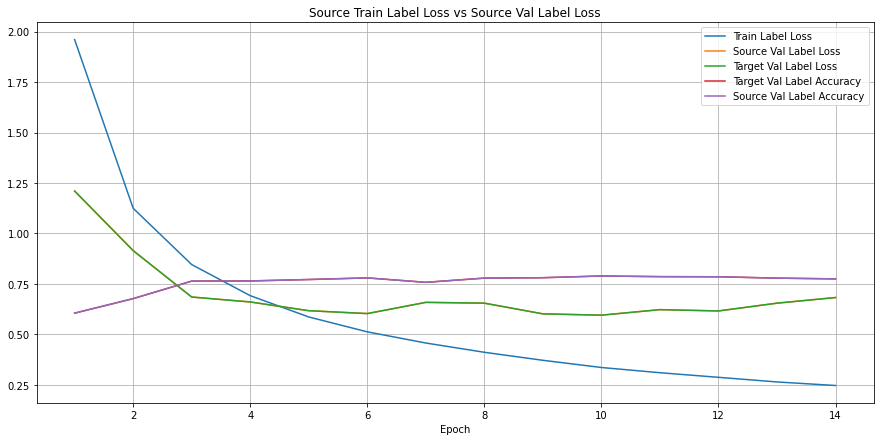

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

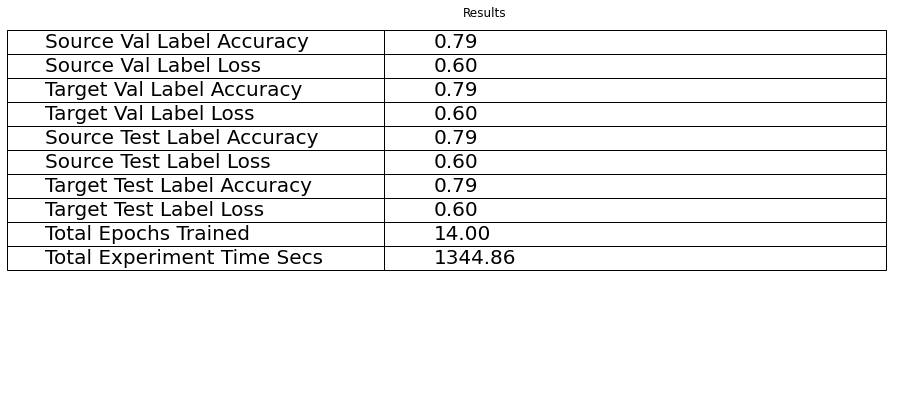

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

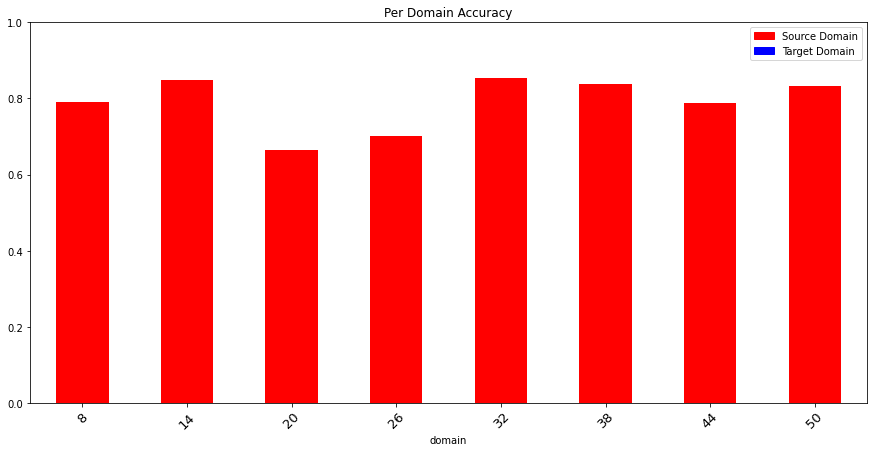

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7883333333333333 Target Test Label Accuracy: 0.7883333333333333
Source Val Label Accuracy: 0.7895208333333333 Target Val Label Accuracy: 0.7895208333333333


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2", "parameters": {"experiment_name": "cnn_2:oracle.run2", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [